In [262]:
import csv
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import preprocessing
import numpy as np
import matplotlib as plt
%matplotlib inline

In [263]:
df = pd.read_csv("cereals.csv")

In [264]:
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
0,100%_Bran,N,C,70,4,1,130,10,5,6,280,25,3,1,0.33
1,100%_Natural_Bran,Q,C,120,3,5,15,2,8,8,135,0,3,1,1.00
2,All-Bran,K,C,70,4,1,260,9,7,5,320,25,3,1,0.33
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14,8,0,330,25,3,1,0.50
4,Almond_Delight,R,C,110,2,2,200,1,14,8,-1,25,3,1,0.75


Looking at this, it's clear that we will have to do something about "mfr" and "type" colummns because they are not numbers. To get some ennumeration, I'm looking at the value counts of them to see if 1) they are important and 2) to get a use-weighted integer to assign to the contents.

## Cleaning Data

In [265]:
df = df.reindex(np.random.permutation(df.index)) # randomize order of data

In [266]:
for col in df.columns:
    print(col.ljust(15)+str(min(df[col])))

name           100%_Bran
mfr            A
type           C
calories       50
protein        1
fat            0
sodium         0
fiber          0.0
carbo          -1.0
sugars         -1
potass         -1
vitamins       0
shelf          1
weight         0.5
cups           0.25


In [267]:
replace_cols = ["carbo", "sugars", "potass"]

In [268]:
avg_cols = [0]*3
for i in range(3):
    avg_cols[i] = sum(df[replace_cols[i]]) / len(df[replace_cols[i]])

In [269]:
for i in range(3): # replace missing things with average value
    col = replace_cols[i]
    df[col] = df[col].replace(-1, avg_cols[i])

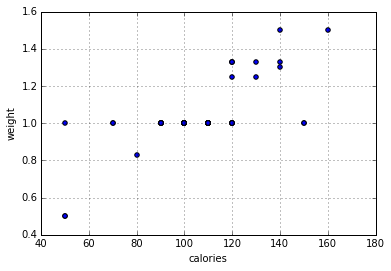

In [270]:
df.plot(kind="scatter", x="calories", y="weight")

Weight and calories are not equivelant, and cups isn't either.

In [271]:
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups
62,Rice_Krispies,K,C,110,2,0,290,0,22,3,35.000000,25,1,1,1.00
64,Shredded_Wheat_'n'Bran,N,C,90,3,0,0,4,19,0,140.000000,0,1,1,0.67
42,Lucky_Charms,G,C,110,2,1,180,0,12,12,55.000000,25,2,1,1.00
20,Cream_of_Wheat_(Quick),N,H,100,3,0,80,1,21,0,96.077922,0,2,1,1.00
61,Rice_Chex,R,C,110,1,0,240,0,23,2,30.000000,25,1,1,1.13


In [272]:
for col in df.columns[3:]:
    df[col] = df[col] / df["weight"]
df = df.drop("weight", axis=1)

In [273]:
df.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,cups
62,Rice_Krispies,K,C,110,2,0,290,0,22,3,35.000000,25,1,1.00
64,Shredded_Wheat_'n'Bran,N,C,90,3,0,0,4,19,0,140.000000,0,1,0.67
42,Lucky_Charms,G,C,110,2,1,180,0,12,12,55.000000,25,2,1.00
20,Cream_of_Wheat_(Quick),N,H,100,3,0,80,1,21,0,96.077922,0,2,1.00
61,Rice_Chex,R,C,110,1,0,240,0,23,2,30.000000,25,1,1.13


## Preprocessing

In [274]:
df["mfr"].value_counts()

K    23
G    22
P     9
Q     8
R     8
N     6
A     1
dtype: int64

In [275]:
df["type"].value_counts()

C    74
H     3
dtype: int64

The hot/cold dichotomy seems to be insignificant enough to just drop. The "mfr" values are renumbered by prevelance, which might help to preserve some "distance" sense.

In [276]:
mfr_numbs = {
    "K":1,
    "G":2,
    "P":3,
    "R":4,
    "Q":5,
    "N":6,
    "A":7
}

In [277]:
df3 = df
df3["mfr"] = df["mfr"].apply(lambda val: mfr_numbs[val]) # applying the ennumeration scheme
df3 = df3.drop("type", axis=1)
df3 = df3.drop("name", axis=1)

In [278]:
df3["cups"].value_counts()

1.00    30
0.75    16
0.67    13
0.50     7
0.33     3
0.88     2
1.25     1
1.33     1
1.13     1
0.80     1
1.50     1
0.25     1
dtype: int64

In [279]:
df3.head() # these are all numbers now

,mfr,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,cups
62,1,110,2,0,290,0,22,3,35.000000,25,1,1.00
64,6,90,3,0,0,4,19,0,140.000000,0,1,0.67
42,2,110,2,1,180,0,12,12,55.000000,25,2,1.00
20,6,100,3,0,80,1,21,0,96.077922,0,2,1.00
61,4,110,1,0,240,0,23,2,30.000000,25,1,1.13


In [280]:
v4 = preprocessing.scale(df3) # converts dataframe to numpy array and does scaling

## Cluster Analysis

In [281]:
groups = pd.DataFrame(index=df.index)
groups["name"] = df["name"]
for i in range(2,10):
    kmeans = KMeans(i)
    kmeans.fit(v4)
    clusters = kmeans.predict(v4)
    col_name = "g"+(str(i).rjust(2)).replace(" ", "0")
    groups[col_name] = clusters

The above code actually applies the k-mean method to the data. But we have used a wide range of number of groups, from 2 to 10. Those were all stored into a dataframe so that we can later try to visualize and understand.

In [282]:
groups.head()

,name,g02,g03,g04,g05,g06,g07,g08,g09
62,Rice_Krispies,0,0,3,0,0,0,2,0
64,Shredded_Wheat_'n'Bran,1,1,0,2,4,2,0,4
42,Lucky_Charms,0,0,1,3,1,6,6,2
20,Cream_of_Wheat_(Quick),1,1,0,2,4,2,0,4
61,Rice_Chex,0,0,3,0,0,0,2,0


In [283]:
big_list = []
for i in range(2,10):
    col_val = groups.columns[i-1]
    lex_list = [[] for k in range(i)]
    for j in range(len(groups)):
        idx = groups[col_val][j]
#        print(idx)
        lex_list[idx].append(groups["name"][j])
    big_list.append(lex_list)

In [284]:
def print_big_list(lex_list):
    '''Organizes the groups from one trial (set number of groups) into a column-based printout'''
    Ncols = min(4, len(lex_list))
    sections = len(lex_list) // Ncols
    for k in range(sections):
        upper_lim = min((k+1)*4, len(lex_list))
        red_list = lex_list[k*4:upper_lim]
        MaxI = max([len(val) for val in lex_list])
        for j in range(Ncols):
            print((" Category "+str(j+k*4)).ljust(28), end="")
        print("")
        for i in range(MaxI):
            for j in range(Ncols):
                if i < len(red_list[j]):
                    print(red_list[j][i][:25].ljust(25)+"   ", end="")
                else:
                    print(" "*28, end="")
            print("")
        print("")
    

In [285]:
print_big_list(big_list[3])

 Category 0                  Category 1                  Category 2                  Category 3                 
Cheerios                    100%_Bran                   Cream_of_Wheat_(Quick)      Apple_Cinnamon_Cheerios     
Corn_Chex                   All-Bran                    Maypo                       Apple_Jacks                 
Corn_Flakes                 All-Bran_with_Extra_Fiber   Puffed_Rice                 Cap'n'Crunch                
Crispix                                                 Puffed_Wheat                Cinnamon_Toast_Crunch       
Double_Chex                                             Shredded_Wheat              Cocoa_Puffs                 
Just_Right_Crunchy__Nugge                               Shredded_Wheat_'n'Bran      Corn_Pops                   
Just_Right_Fruit_&_Nut                                  Shredded_Wheat_spoon_size   Count_Chocula               
Kix                                                     Strawberry_Fruit_Wheats     Froot_Loops 

We have 4 columns here. A general eyeballing of the contents suggests categories of:
 - Generic flakes and Os
 - Sugar cereals
 - The "naturals" category
 - Exclusively fiber stuff

In [286]:
print_big_list(big_list[6])

 Category 0                  Category 1                  Category 2                  Category 3                 
Cream_of_Wheat_(Quick)      Almond_Delight              Cheerios                    100%_Natural_Bran           
Maypo                       Basic_4                     Corn_Chex                   Muesli_Raisins,_Dates,_&_   
Quaker_Oatmeal              Bran_Chex                   Corn_Flakes                 Muesli_Raisins,_Peaches,_   
Shredded_Wheat              Bran_Flakes                 Crispix                                                 
Shredded_Wheat_'n'Bran      Clusters                    Kix                                                     
Shredded_Wheat_spoon_size   Cracklin'_Oat_Bran          Multi-Grain_Cheerios                                    
Strawberry_Fruit_Wheats     Crispy_Wheat_&_Raisins      Nutri-grain_Wheat                                       
                            Double_Chex                 Rice_Chex                               

Breaking it up into 8 categories, we see the emergence of new classes of cereals.
 - "Puff" cereals
 - Weight-loss cereals
 - Rains and dates
 - bran

# Predicting category of Bran flakes from Trader Joes

In [292]:
kmeans = KMeans(4)
kmeans.fit(v4)
clusters = kmeans.predict(v4)

lex_list = [[] for k in range(4)]
for j in range(len(clusters)):
    idx = clusters[j]
    lex_list[idx].append(df["name"][j])
print_big_list(lex_list)

 Category 0                  Category 1                  Category 2                  Category 3                 
100%_Natural_Bran           100%_Bran                   All-Bran                    Corn_Flakes                 
All-Bran_with_Extra_Fiber   Almond_Delight              Bran_Chex                   Maypo                       
Apple_Cinnamon_Cheerios     Cocoa_Puffs                 Cheerios                    Oatmeal_Raisin_Crisp        
Apple_Jacks                 Crispix                     Corn_Chex                                               
Basic_4                     Frosted_Mini-Wheats         Corn_Pops                                               
Bran_Flakes                 Great_Grains_Pecan          Count_Chocula                                           
Cap'n'Crunch                Honey_Graham_Ohs            Cracklin'_Oat_Bran                                      
Cinnamon_Toast_Crunch       Lucky_Charms                Double_Chex                             

In [295]:
df3.ix[0]

mfr           6.00
calories     70.00
protein       4.00
fat           1.00
sodium      130.00
fiber        10.00
carbo         5.00
sugars        6.00
potass      280.00
vitamins     25.00
shelf         3.00
cups          0.33
Name: 0, dtype: float64

In [296]:
kmeans.predict(df3.ix[0])

array([3], dtype=int32)

In [299]:
# Bran flakes data
BF = [6., 100., 3., 0.5, 220., 5., 24., 6., 170., 35., 3., 0.75]

In [300]:
kmeans.predict(BF)

array([3], dtype=int32)

It gets grouped in with the Corn Flakes and oatmeal cereal. That seems reasonable.